#### Install dependencies

In [ ]:
!pip install -U scikit-learn -q
!pip install seaborn -q
!pip install sqlalchemy psycopg2 -q
!pip install openpyxl -q

In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


### Download retail dataset

In [13]:
!curl -O https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.5M    0 43.5M    0     0   933k      0 --:--:--  0:00:47 --:--:--  930k:00:02 --:--:-- 1099k    0   903k      0 --:--:--  0:00:19 --:--:--  861k-:-- 1079k  0   931k      0 --:--:--  0:00:47 --:--:--  923k


In [2]:
!yes | unzip online+retail+ii.zip -d .

Archive:  online+retail+ii.zip
replace ./online_retail_II.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: ./online_retail_II.xlsx  
yes: stdout: Broken pipe


### Reading retail dataset into Pandas dataframe

In [3]:
transactions_df = pd.read_excel('online_retail_II.xlsx')

In [15]:
transactions_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Dropping rows with N/A values, renaming columns.

In [4]:
transactions_df_cp = transactions_df.copy()
transactions_df_cp = transactions_df_cp.dropna()
transactions_df_cp.columns = ['invoice_id', 'product_id', 'description', 'quantity', 'invoice_date',
                              'price', 'customer_id', 'country']

transactions_df_cp['customer_id'] = transactions_df_cp['customer_id'].astype(int)

#### Example: show customer transactions before featurization

In [5]:
CUSTOMER_ID_EXAMPLE = 13085
transactions_df_cp[transactions_df_cp.customer_id == CUSTOMER_ID_EXAMPLE]

,invoice_id,product_id,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
74409,496166,79323W,WHITE CHERRY LIGHTS,8,2010-01-29 11:42:00,6.75,13085,United Kingdom
74410,496166,21137,BLACK RECORD COVER FRAME,8,2010-01-29 11:42:00,3.75,13085,United Kingdom
74411,496166,22041,"RECORD FRAME 7"" SINGLE SIZE",6,2010-01-29 11:42:00,2.55,13085,United Kingdom
74412,496166,40046A,RED DAISY PAPER LAMPSHADE,12,2010-01-29 11:42:00,1.25,13085,United Kingdom


### Defining Customers' Features

In [6]:
def is_weekend(transaction_date):
    # Check if the day of the week is either Saturday (5) or Sunday (6)
    return transaction_date.weekday() in [5, 6]

In [16]:
def generate_customer_features(df):
    df['is_weekend'] = df['invoice_date'].apply(is_weekend)
    # Group the DataFrame by 'Customer ID'
    grouped = df.groupby('customer_id')
    
    
    # Calculate the average basket size by customer
    avg_basket_size = grouped['quantity'].mean()
    
    # Calculate the average monthly transaction price by customer (excluding the refunds)
    df['transaction_price'] = df['quantity'] * df['price']
    df['transaction_price'] = df.apply(lambda row: row['quantity'] * row['price'] 
                                       if row['quantity'] > 0 and row['price'] > 0 else 0, axis=1
                                      )
    df['year_month'] = df['invoice_date'].dt.to_period('M')
    avg_monthly_transaction_price = df.groupby(['customer_id', 'year_month'])['transaction_price'].sum().groupby('customer_id').mean()
    
    # Calculate the average quantity * price on weekends by customer
    avg_weekend_quantity_price = grouped.apply(lambda x: (x['is_weekend'] * x['transaction_price']).mean())
    
    # Calculate the average monthly returns by customer
    df['returns'] = df['quantity'] * df['price'] < 0
    avg_monthly_returns = df.groupby(['customer_id', 'year_month'])['returns'].mean().groupby('customer_id').mean()
    
    
    # Create a DataFrame to store the customer features
    customer_features = pd.DataFrame({
        'average_basket_size': avg_basket_size,
        'average_monthly_transaction_price': avg_monthly_transaction_price,
        'average_weekend_transaction_price': avg_weekend_quantity_price,
        'average_monthly_returns': avg_monthly_returns
    })
    
    return customer_features

In [17]:
# Generate customer features
customer_features = generate_customer_features(transactions_df_cp)

#### Show CUSTOMER_ID_EXAMPLE customer after Featurization and before Scaling

In [10]:
customer_features[customer_features.index == CUSTOMER_ID_EXAMPLE]

,average_basket_size,average_monthly_transaction_price,average_weekend_transaction_price,average_monthly_returns
customer_id,,,,
13085,11.539683,672.4,0.0,0.333333


In [18]:
customer_features

,average_basket_size,average_monthly_transaction_price,average_weekend_transaction_price,average_monthly_returns
customer_id,,,,
12346,1.130435,74.572000,0.000000,0.308966
12347,11.661972,661.660000,8.613099,0.000000
12348,18.650000,222.160000,0.000000,0.000000
12349,9.233645,667.785000,0.000000,0.250000
12351,12.428571,300.930000,0.000000,0.000000
...,...,...,...,...
18283,1.460870,160.442500,0.627609,0.000000
18284,17.000000,461.680000,0.000000,0.034483
18285,12.083333,427.000000,0.000000,0.000000


#### Scaling features between 0 and 1

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate the Min-Max Scaler
scaler = MinMaxScaler()

# Fit the scaler on the data and transform the data
scaled_customer_features = scaler.fit_transform(customer_features)

# Convert the scaled data back to a DataFrame
scaled_customer_features_df = pd.DataFrame(scaled_customer_features, columns=customer_features.columns)
scaled_customer_features_df2 = scaled_customer_features_df.copy()
scaled_customer_features_df2['customer_id'] = customer_features.index


In [20]:
scaled_customer_features_df2[scaled_customer_features_df2.customer_id == CUSTOMER_ID_EXAMPLE]

,average_basket_size,average_monthly_transaction_price,average_weekend_transaction_price,average_monthly_returns,customer_id
507,0.006873,0.025035,0.0,0.333333,13085


In [14]:
scaled_customer_features_df.shape

(4383, 4)

### Clustering customers' scaled features

In [12]:
from sklearn.cluster import KMeans

# Number of clusters (K)
n_clusters = 3

# Instantiate the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=43)

# Fit the model to the scaled data
kmeans.fit(scaled_customer_features_df)

# Add cluster labels to the original customer features DataFrame
customer_features['Cluster'] = kmeans.labels_

# merge the clusters with the original dataframe
transactions_with_clusters_df = pd.merge(transactions_df_cp, customer_features, on='customer_id')


/Users/elshater/workspace/python_venv/embeddings_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Visualizing Clusters

/var/folders/5k/vj_g89cj1vb_84xn4jd13r840000gs/T/ipykernel_3148/2910456623.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[0])
/var/folders/5k/vj_g89cj1vb_84xn4jd13r840000gs/T/ipykernel_3148/2910456623.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[1])


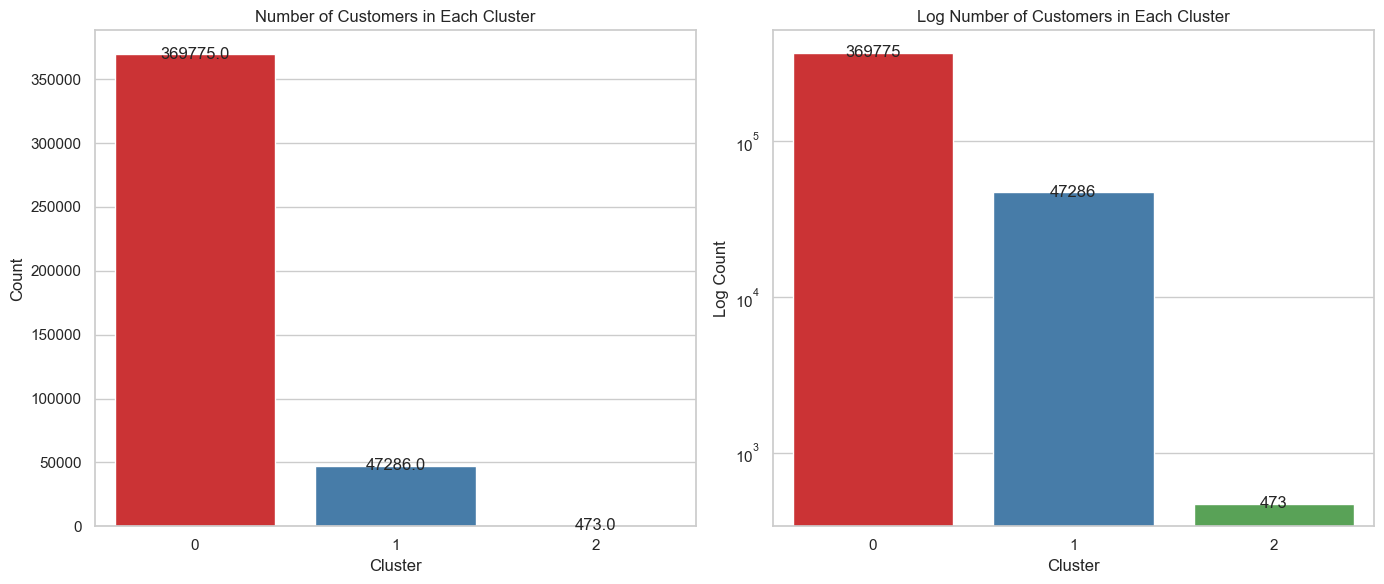

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create subplots for both the regular and log-transformed plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Number of customers in each cluster
sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[0])
axes[0].set_title('Number of Customers in Each Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')

# Annotate the bars with the count values on top
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Plot 2: Log-transformed number of customers in each cluster
sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[1])
axes[1].set_yscale('log')  # Apply log scale to the y-axis
axes[1].set_title('Log Number of Customers in Each Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Log Count')

# Annotate the bars with the count values on top (log scale)
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


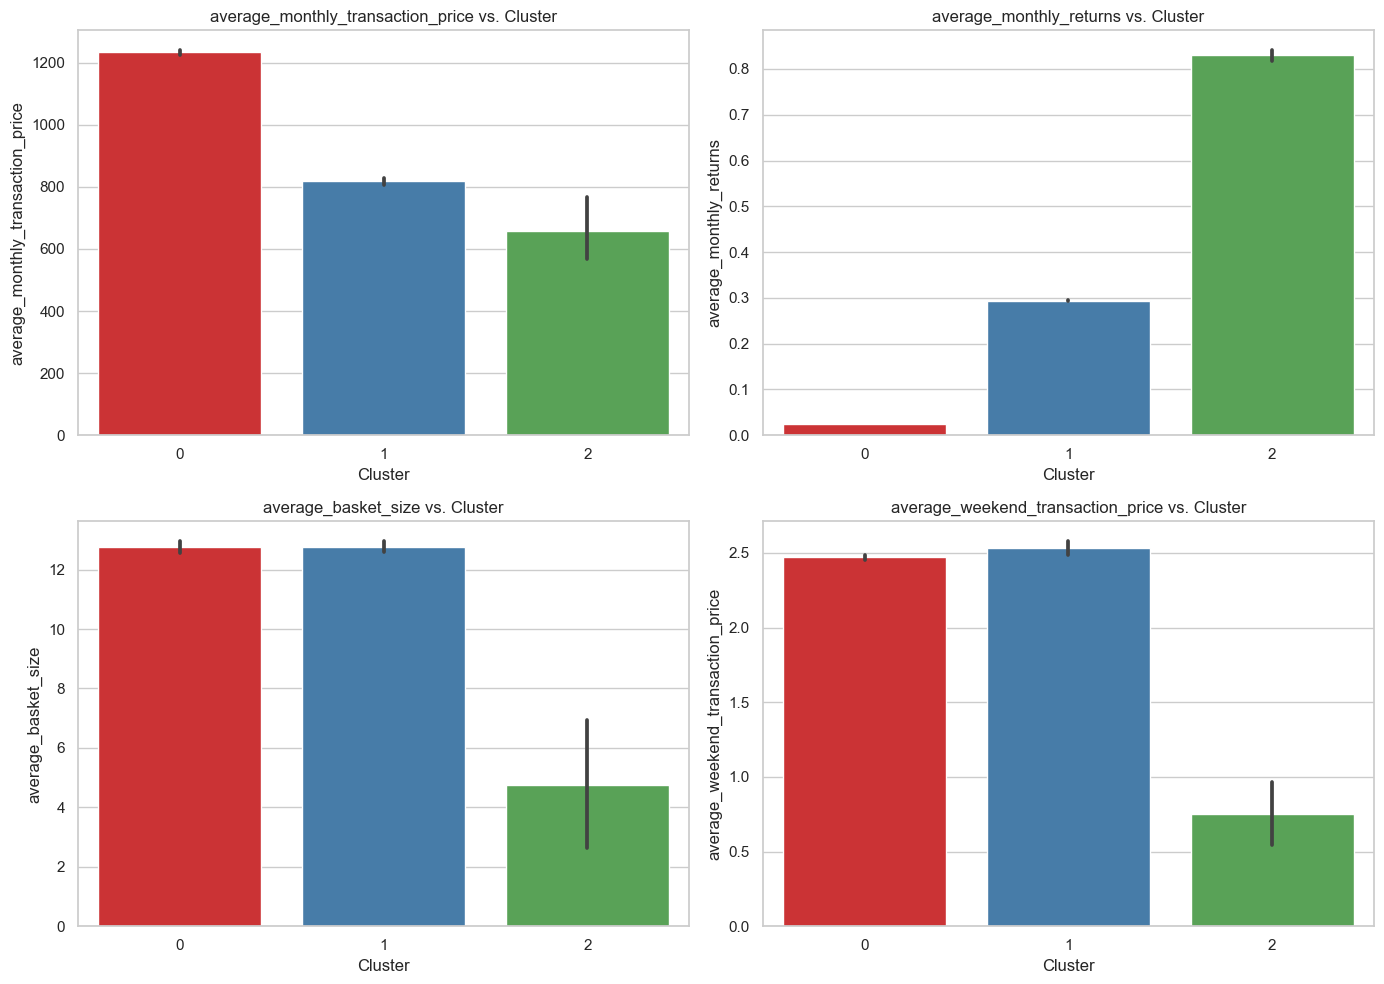

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style of the plots
sns.set(style="whitegrid")

# Define a list of features to visualize
features_to_visualize = ['average_monthly_transaction_price', 'average_monthly_returns','average_basket_size','average_weekend_transaction_price']

# Create subplots for each feature
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    sns.barplot(data=transactions_with_clusters_df, x='Cluster', y=feature, palette='Set1')
    plt.title(f'{feature} vs. Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


/var/folders/5k/vj_g89cj1vb_84xn4jd13r840000gs/T/ipykernel_9595/1462318893.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=transactions_with_clusters_df, x='Cluster', y='average_monthly_transaction_price', palette='Set1')


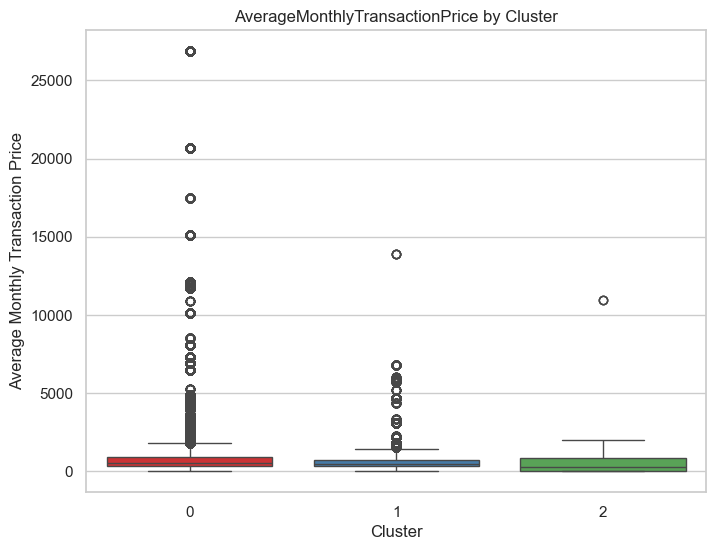

In [36]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a box plot for AverageMonthlyTransactionPrice by Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(data=transactions_with_clusters_df, x='Cluster', y='average_monthly_transaction_price', palette='Set1')
plt.title('AverageMonthlyTransactionPrice by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monthly Transaction Price')
plt.show()

#### Visualizing the Customer Clusters in 2-D dimensions

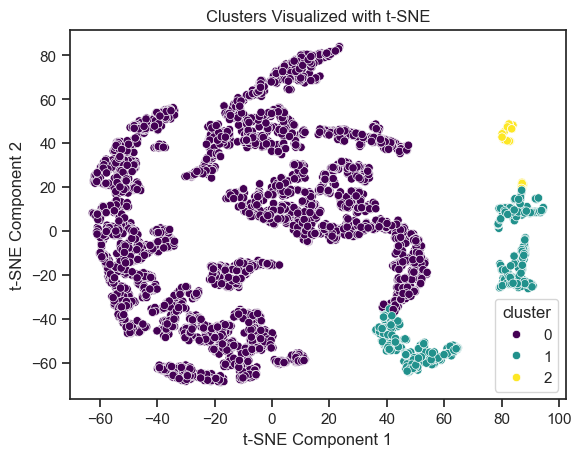

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Apply t-SNE to reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42, n_iter=2000)
X_tsne = tsne.fit_transform(scaled_customer_features)

# Add the cluster information to the reduced data
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])
df_tsne['cluster'] = kmeans.labels_

# Plotting
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_tsne, palette='viridis')
plt.title('Clusters Visualized with t-SNE')
plt.show()

## Vector Database

### Insert the centroids into database

In [61]:
scaled_customer_features_cp = scaled_customer_features_df.copy() 
scaled_customer_features_cp['cluster'] = kmeans.labels_
centroids_df = scaled_customer_features_cp.groupby(['cluster']).mean()

In [67]:
embeddings_columns = ['average_basket_size', 'average_monthly_transaction_price', 'average_weekend_transaction_price', 'average_monthly_returns']
np.array(centroids_df[embeddings_columns])

array([[9.18912978e-03, 1.74937152e-02, 7.31837959e-03, 1.54195425e-02],
       [7.74209638e-03, 1.80989572e-02, 6.71662231e-03, 3.36005805e-01],
       [3.86340105e-03, 7.63227076e-03, 2.27068980e-04, 9.45975716e-01]])

In [88]:
connection = engine.raw_connection()
cursor = connection.cursor()
# Store all the generated embeddings back into the database.
# First, delete the centroids if any. Ideally, we should delete centroids with specific version.
cursor.execute("DELETE FROM centroids")
connection.commit()
for index, row in centroids_df.iterrows():
    cursor.execute(
        "INSERT INTO centroids (cluster_id, embedding) VALUES (%s, %s)",
        (index,
        row[embeddings_columns].values.tolist()),
    )
    #print(index)
    #print(row[embeddings_columns].values)
connection.commit()
cursor.close()


In [148]:
connection = engine.raw_connection()
cursor = connection.cursor()
customer_index = 5
customer_feature_vector = scaled_customer_features_cp[embeddings_columns].values.tolist()[customer_index]
expected_cluster = scaled_customer_features_cp['cluster'].tolist()[customer_index]

#cursor.execute ("""SELECT cluster_id FROM centroids ORDER BY embedding <-> %s""", (str(customer_feature_vector)))
cursor.execute("""SELECT cluster_id FROM centroids ORDER BY embedding <-> '[%s,%s,%s,%s]' limit 1""", tuple(customer_feature_vector))
results = cursor.fetchall()

assert results[0][0] == expected_cluster

#### Optional -- Bulk insert transactions into database

In [ ]:
# Database connection parameters
db_url = "postgresql://{}:{}@localhost:{}/customers_transactions_db".format(
    os.environ['POSTGRESS_USERNAME'],
    os.environ['POSTGRESS_PASSWORD'],
    os.environ['POSTGRESS_PORT']
)

# Create a database connection
engine = create_engine(db_url)

# Define the table name
table_name = 'transactions'

# Insert the DataFrame into the PostgreSQL table
transactions_df_cp.to_sql(table_name, engine, if_exists='replace', index=False)